# Global Imports

In [1]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
from einops import rearrange
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn
from typing import Any
import glob
import re
from datetime import datetime
import random

random.seed(42)

# Local Imports

In [2]:
from training.train import EpochLogs, grid_search, LogPoint
from dataset.character_dataset import CharImageDataset
from models.allcnn2d import AllCNN2D

# Globals

In [3]:
DATASET_SPLIT: float = 0.8
MODEL_NAME: str = "Beta"

# Define Paths
Workspace

In [4]:
notebook_dir: str = os.path.abspath(".")
root_dir: str = os.path.join(
    notebook_dir,
    os.pardir,
    os.pardir
)

data_dir: str = os.path.join(
    root_dir,
    "data",
    "lambda"
)

model_save_dirpath: str = os.path.join(
    root_dir,
    "models",
    "allcnn"
)


Image paths

In [5]:

images_path_glob: str = os.path.join(
    data_dir,
    "u*.png"
)
images_path_regex: str = r"(u[0-9a-fA-F]+)-([0-9]+)\.png"

image_paths: list[str] = glob.glob(images_path_glob)
random.shuffle(image_paths)


# Helper Functions

In [6]:
def get_current_time() -> str:
    return datetime.now().strftime("%Y-%m-%d-%H-%M-%S")


# Logging Setup 

In [7]:

logging_path: str = f"{MODEL_NAME}_log_{get_current_time()}.csv"

with open(logging_path, "w") as f:
    f.write("TIME,EPOCH,TRAIN_ACC,VAL_ACC,TRAIN_LOSS,VAL_LOSS,LR\n")

def log(
    epoch: int,
    train_acc: float, 
    train_loss: float, 
    val_acc: float, 
    val_loss, 
    lr: float
)-> None:
    with open(logging_path, "a") as f:
        f.write(f"{get_current_time()},{epoch},{train_acc},{val_acc},{train_loss},{val_loss},{lr}\n")

# Extract Labels

In [8]:

labeled_image_paths: list[tuple[str, str]] = []

file_path: str
for file_path in image_paths:
    match = re.search(images_path_regex, file_path)
    
    if not match:
        continue
    
    u_hexvalue: str = match.group(1)
    labeled_image_paths.append((u_hexvalue, file_path))

labels: list[str]
image_paths: list[str]
labels, image_paths =  list(zip(*labeled_image_paths))


# Load Dataset

In [9]:

split_index: int = int(len(image_paths)*DATASET_SPLIT)
all_label_classes: list[str] = list(set(labels))

train_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[:split_index],
    labels=labels[:split_index],
    all_label_classes=all_label_classes,
    rotation_limit=0.1,
    translation_limit=0.2,
    skew_limit=0.05,
    zoom_change=0.3,
    image_dims=(64, 64)
)

val_char_dataset: CharImageDataset = CharImageDataset(
    file_paths=image_paths[split_index:],
    labels=labels[split_index:],
    all_label_classes=all_label_classes,
    rotation_limit=0.0,
    translation_limit=0.0,
    skew_limit=0.00,
    zoom_change=0.0,
    image_dims=(64, 64)
)




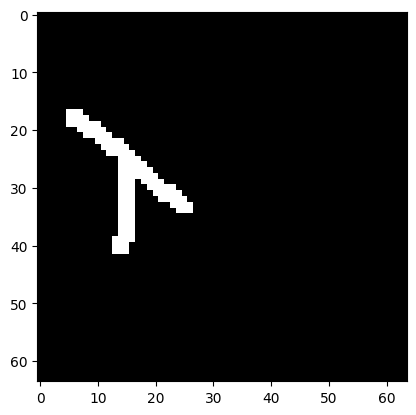

tensor([0., 0., 0., 0., 0., 1., 0.])


In [10]:
for im, lab in train_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

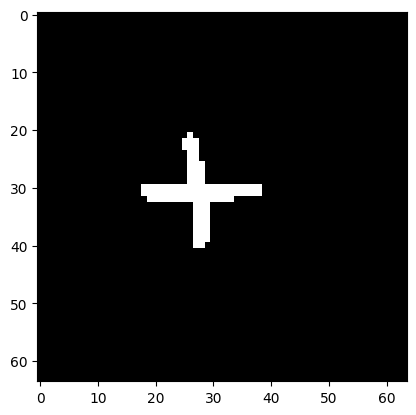

tensor([0., 0., 1., 0., 0., 0., 0.])


In [11]:
for im, lab in val_char_dataset:
    plt.imshow(rearrange(im, "1 h w -> h w")*255, cmap="gray")
    plt.show()
    print(lab)
    break

# Load DataLoader

In [12]:
train_dataloader: DataLoader = DataLoader(
    train_char_dataset,
    shuffle=True,
    batch_size=16
)

val_dataloader: DataLoader = DataLoader(
    val_char_dataset,
    shuffle=False,
    batch_size=16
)

# Define Model Hyperparameters

In [13]:

model_checkpoint_path: str = os.path.join(
    model_save_dirpath,
    "AlphaAllCNN_epoch8_trainacc0.30147_valacc0.014493.pkl"
)

all_model_parameters: list[dict[str, Any]] = [
    {
        "conv_features": (1, 16, 16, 16, 16, 16, 16, 32),
        "fully_connected_features": (32,7),
        "expected_input_size": (64, 64),
        "device": "cuda",
        "conv_dropout": 0.1,
        "verbose": True,
        "name_prefix": MODEL_NAME,
        "checkpoint_path": model_checkpoint_path
    }
]

all_optim_parameters: list[dict[str, Any]] = [
    {
        "lr": 0.001,
        "weight_decay": 0.0001
    }
]


In [14]:
len(val_dataloader)

5

# Train

In [ ]:

for epoch in range(10000):

    epoch_log: EpochLogs
    for epoch_log in grid_search(
        model_factory=AllCNN2D,
        all_model_parameters=all_model_parameters,
        optim_factory=AdamW,
        all_optim_params=all_optim_parameters,
        epochs=100,
        criterion=nn.CrossEntropyLoss(),
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        lr_decay_window_size=10,
        lr_decay_minimum=0.0,
        scheduler_scale=0.5,
        device="cuda"
    ):
        train_logpoints: list[LogPoint] = epoch_log.train_logs
        val_logpoints: list[LogPoint] = epoch_log.val_logs
        
        
        train_count: int = 0
        val_count: int = 0
        
        train_losses_tally: float = 0.0
        val_losses_tally: float = 0.0
        
        train_correct_tally: int = 0
        val_correct_tally: int = 0
        
        for log_point in train_logpoints: 
            
            y_hat_pred: torch.Tensor = torch.argmax(
                log_point.y_hat, 
                axis=-1
            ).detach().cpu()
            
            y_pred: torch.Tensor = torch.argmax(
                log_point.y, axis=-1
            ).detach().cpu()

            train_correct_tally += torch.sum(y_hat_pred==y_pred)
            
            train_losses_tally += torch.sum(log_point.loss)
            
            train_count += len(y_hat_pred)
            
        for log_point in val_logpoints: 
            
            y_hat_pred: torch.Tensor = torch.argmax(
                log_point.y_hat, 
                axis=-1
            ).detach().cpu()
            
            y_pred: torch.Tensor = torch.argmax(
                log_point.y, axis=-1
            ).detach().cpu()

            val_correct_tally += torch.sum(y_hat_pred==y_pred)
            
            val_losses_tally += torch.sum(log_point.loss)
            
            val_count += len(y_hat_pred)
            
        train_accuracy: float = train_correct_tally/train_count
        val_accuracy: float = val_correct_tally/val_count
        
        train_loss: float = train_losses_tally/train_count
        val_loss: float = val_losses_tally/val_count
        
        cur_learning_rate: float = epoch_log.optimiser.param_groups[0]["lr"]
        
        model_checkpoint_path: str = os.path.join(
            model_save_dirpath,
            f"{MODEL_NAME}_epoch{epoch_log.epoch}_trainacc{train_accuracy:.5}_valacc{val_accuracy:.5}.pkl"
        )
        
        with open(model_checkpoint_path, "wb") as f:
            torch.save(epoch_log.model.state_dict(), f)
        
        print(f"Train Accuracy      : {train_accuracy}")
        print(f"Val Accuracy        : {val_accuracy}")
        print(f"Loss                : {train_loss}")
        print(f"Val Loss            : {val_loss}")
        print(f"Learning Rate       : {cur_learning_rate}")
        
        log(
            epoch_log.epoch,
            train_accuracy,
            train_loss,
            val_accuracy,
            val_loss,
            cur_learning_rate
        )

Loaded: encoder_conv_blocks.0.0.weight

c:\Users\Leon\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()



Loaded: encoder_conv_blocks.0.0.bias
Loaded: encoder_conv_blocks.0.2.weight
Loaded: encoder_conv_blocks.0.2.bias
Loaded: encoder_conv_blocks.0.2.running_mean
Loaded: encoder_conv_blocks.0.2.running_var
Loaded: encoder_conv_blocks.0.2.num_batches_tracked
Loaded: encoder_conv_blocks.0.4.weight
Loaded: encoder_conv_blocks.0.4.bias
Loaded: encoder_conv_blocks.0.6.weight
Loaded: encoder_conv_blocks.0.6.bias
Loaded: encoder_conv_blocks.0.6.running_mean
Loaded: encoder_conv_blocks.0.6.running_var
Loaded: encoder_conv_blocks.0.6.num_batches_tracked
Skipping encoder_conv_blocks.1.0.weight:  loaded size:torch.Size([32, 16, 3, 3]) != model size:  torch.Size([16, 16, 3, 3])
Skipping encoder_conv_blocks.1.0.bias:  loaded size:torch.Size([32]) != model size:  torch.Size([16])
Skipping encoder_conv_blocks.1.2.weight:  loaded size:torch.Size([32]) != model size:  torch.Size([16])
Skipping encoder_conv_blocks.1.2.bias:  loaded size:torch.Size([32]) != model size:  torch.Size([16])
Skipping encoder_con

Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]


Train Accuracy      : 0.13970588147640228
Val Accuracy        : 0.15942029654979706
Loss                : 0.12204380333423615
Val Loss            : 0.14026100933551788
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.1875
Val Accuracy        : 0.15942029654979706
Loss                : 0.12122810631990433
Val Loss            : 0.14200758934020996
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Accuracy      : 0.20955882966518402
Val Accuracy        : 0.18840579688549042
Loss                : 0.11911924928426743
Val Loss            : 0.14152903854846954
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Train Accuracy      : 0.24632352590560913
Val Accuracy        : 0.21739129722118378
Loss                : 0.11732690036296844
Val Loss            : 0.1349598467350006
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]


Train Accuracy      : 0.24632352590560913
Val Accuracy        : 0.3333333432674408
Loss                : 0.11412256211042404
Val Loss            : 0.12754669785499573
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]


Train Accuracy      : 0.25735294818878174
Val Accuracy        : 0.21739129722118378
Loss                : 0.11113856732845306
Val Loss            : 0.12262692302465439
Learning Rate       : 0.001


Validating Model...: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


Train Accuracy      : 0.24632352590560913
Val Accuracy        : 0.23188406229019165
Loss                : 0.11075931787490845
Val Loss            : 0.11928322166204453
Learning Rate       : 0.001


Training model...:  65%|██████▍   | 11/17 [00:08<00:04,  1.23it/s]